In [1]:
%cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
%load_ext autoreload
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
from matplotlib.gridspec import GridSpec
import polars.selectors as cs

import tarfile
import json
import pandas as pd 
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

In [3]:
exp_name = (
    "0332-92xkckqk"
)
df_raw = read_logs(exp_name=exp_name, exp_path=None)

In [4]:
df_raw=df_raw.with_columns(
    cs.contains("time_join").fill_null(0)
)

In [5]:
df_raw.columns

['scenario_id',
 'status',
 'target_dl',
 'jd_method',
 'base_table',
 'query_column',
 'estimator',
 'aggregation',
 'chosen_model',
 'fold_id',
 'time_fit',
 'time_predict',
 'time_run',
 'time_prepare',
 'time_model_train',
 'time_join_train',
 'time_model_predict',
 'time_join_predict',
 'peak_fit',
 'peak_predict',
 'peak_test',
 'r2score',
 'rmse',
 'f1score',
 'auc',
 'n_cols',
 'budget_type',
 'budget_amount',
 'epsilon']

In [6]:
results = df_raw.filter(pl.col("chosen_model") == "catboost").group_by("estimator").agg(
    # pl.col("time_fit").mean(),
    # pl.col("time_predict").mean(),
    # pl.col("time_run").mean(),
    pl.col("time_prepare").mean(),
    pl.col("time_model_train").mean(),
    pl.col("time_join_train").mean(),
    pl.col("time_model_predict").mean(),
    pl.col("time_join_predict").mean(),
).melt(id_vars="estimator")

In [7]:
results

estimator,variable,value
str,str,f64
"""best_single_join""","""time_prepare""",0.045794
"""full_join""","""time_prepare""",0.063064
"""highest_containment""","""time_prepare""",13.699701
"""stepwise_greedy_join""","""time_prepare""",19.562097
"""nojoin""","""time_prepare""",0.065456
"""best_single_join""","""time_model_train""",83.295438
"""full_join""","""time_model_train""",23.084148
"""highest_containment""","""time_model_train""",7.189362
"""stepwise_greedy_join""","""time_model_train""",540.671946


In [8]:
dicts = results.group_by(
    "estimator"
).agg(pl.all()).to_dicts()

In [9]:
d = dicts[0]

In [10]:
to_concat = []
for _, gr in results.group_by(
    "estimator"
):
    new_g = gr.sort("variable").with_columns(
        pl.col("value").cumsum().alias("csum")
    ).with_columns(
        pl.col("csum").alias("bottom").shift(1).fill_null(0),
    )
    to_concat.append(new_g)
df_c = pl.concat(to_concat)

In [11]:
new_g

estimator,variable,value,csum,bottom
str,str,f64,f64,f64
"""nojoin""","""time_join_predict""",0.0,0.0,0.0
"""nojoin""","""time_join_train""",0.0,0.0,0.0
"""nojoin""","""time_model_predict""",0.112269,0.112269,0.0
"""nojoin""","""time_model_train""",1.42061,1.532879,0.112269
"""nojoin""","""time_prepare""",0.065456,1.598335,1.532879


In [12]:
dicts = df_c.group_by("variable").agg(pl.all()).sort("variable").to_dicts()

In [13]:
df_c.group_by("variable").agg(pl.all()).sort("variable")

variable,estimator,value,csum,bottom
str,list[str],list[f64],list[f64],list[f64]
"""time_join_predict""","[""best_single_join"", ""stepwise_greedy_join"", … ""nojoin""]","[50.314468, 44.887169, … 0.0]","[50.314468, 44.887169, … 0.0]","[0.0, 0.0, … 0.0]"
"""time_join_train""","[""best_single_join"", ""stepwise_greedy_join"", … ""nojoin""]","[722.143547, 288.094738, … 0.0]","[772.458015, 332.981907, … 0.0]","[50.314468, 44.887169, … 0.0]"
"""time_model_predict""","[""best_single_join"", ""stepwise_greedy_join"", … ""nojoin""]","[0.139617, 0.0624, … 0.112269]","[772.597633, 333.044307, … 0.112269]","[772.458015, 332.981907, … 0.0]"
"""time_model_train""","[""best_single_join"", ""stepwise_greedy_join"", … ""nojoin""]","[83.295438, 540.671946, … 1.42061]","[855.893071, 873.716253, … 1.532879]","[772.597633, 333.044307, … 0.112269]"
"""time_prepare""","[""best_single_join"", ""stepwise_greedy_join"", … ""nojoin""]","[0.045794, 19.562097, … 0.065456]","[855.938864, 893.278349, … 1.598335]","[855.893071, 873.716253, … 1.532879]"


time_join_predict
[50.31446783809524, 44.88716895238095, 311.6546859333334, 41.41888125714286, 0.0]
time_join_train
[772.4580151428573, 332.98190692857133, 935.3299812857144, 123.60685917619047, 0.0]
time_model_predict
[772.5976325952383, 333.0443069238094, 935.7350218142859, 123.74167575714284, 0.11226911904761905]
time_model_train
[855.8930706047621, 873.7162525952381, 958.8191699142859, 130.93103729047618, 1.532879238095238]
time_prepare
[855.9388643142859, 893.2783493523809, 958.8822342238097, 144.63073804761905, 1.5983351714285714]


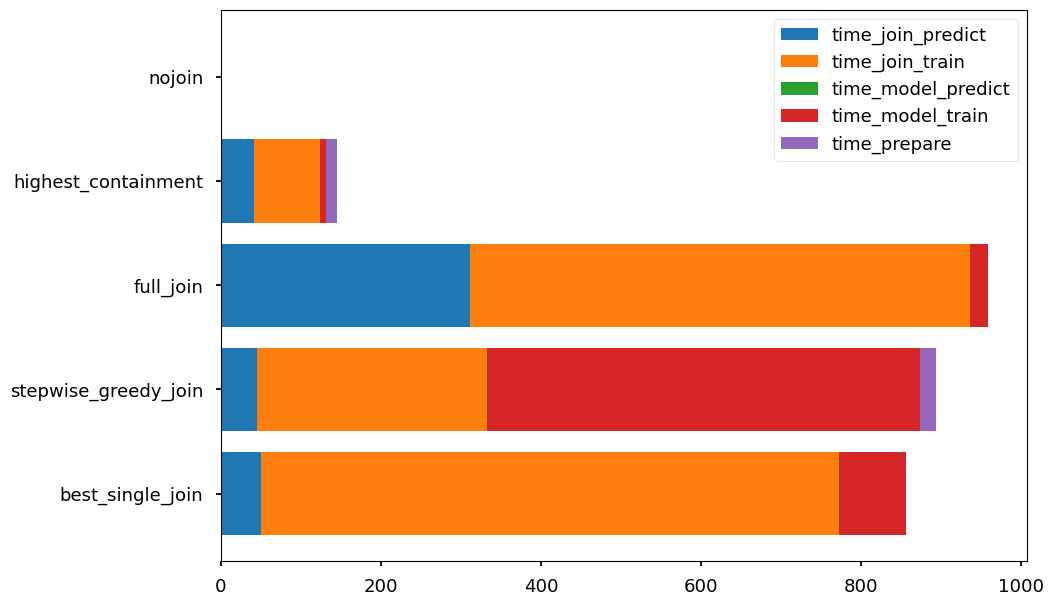

In [20]:
axs = plt.subplot(111)
for idx, d in enumerate(dicts):
    print(d["variable"])
    print(d["csum"])
    p = axs.barh(y=d["estimator"], width = d["value"], left=d["bottom"], label=d["variable"])
    # axs.bar_label(p,)
axs.legend()